In [21]:
import numpy as np
import copy
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#calculates sequence of comparisons, whether they swap and number of least necessary comparisons for an array with a certain order (for example: 6 4 3 1 5 2)
#_f means forward and _b means backward
def imit_seq(array):
    aa=copy.copy(array)
    comp_seq=[]
    swap_or_not=[]
    ii_f=0
    nn=0
    while nn<30:
        
        if aa[ii_f]<aa[ii_f+1]: #correct ofer and keep going forward
            comp_seq.append([ii_f,ii_f+1])
            swap_or_not.append(0)
            nn+=1
            ii_f+=1
        else: #switch when going forward
            comp_seq.append([ii_f,ii_f+1])
            aa[ii_f],aa[ii_f+1]=aa[ii_f+1],aa[ii_f]
            swap_or_not.append(1)
            nn+=1

            ii_b=ii_f
            ii_f+=1

            while nn<30:
                if ii_b==0: #back to position zero
                    break
                if aa[ii_b-1]>aa[ii_b]: #switch and keep going back
                    comp_seq.append([ii_b-1,ii_b])
                    swap_or_not.append(1)
                    aa[ii_b-1],aa[ii_b]=aa[ii_b],aa[ii_b-1]
                    nn+=1
                    ii_b-=1
                if aa[ii_b-1]<aa[ii_b]: #stop going back
                    if ii_b==0:
                        break
                    else:
                        comp_seq.append([ii_b-1,ii_b])
                        swap_or_not.append(0)
                        nn+=1
                        break
        if (aa==np.array(range(1, len(array)+1, 1))).all():
            if np.array([len(array)-2,len(array)-1]) in np.array(comp_seq):
                break
    # return array,nn,comp_seq,swap_or_not
    return comp_seq




# #verify n_nece_compare
# arr_test=np.array([6,4,3,1,5,2]) #13
# arr_test=np.array([1, 2, 3, 4, 8, 7, 6, 5])
# # arr_test=np.array([2,1,4,3,6,5]) #7
# # arr_test=np.array([4,6,3,2,5,1]) #13

# print(imit_seq(arr_test))

In [3]:
import duckdb
import pandas as pd

# Read the CSV file
participants = pd.read_csv('data/participants.csv')  
comparisons = pd.read_csv('data/comparisons.csv')  
orderings = pd.read_csv('data/orderings.csv')  
networks = pd.read_csv('data/networks.csv')  

# Create a DuckDB connection
con = duckdb.connect()

# Register the dataframe as a table
con.register('participants', participants)
con.register('comparisons', comparisons)
con.register('orderings', orderings)
con.register('networks', networks)

In [4]:

# 1. Basic overview of participants per participant
query1 = """
CREATE OR REPLACE TABLE Comp_Table AS
    SELECT 
        participant_id as pid,
        trial_index as tid,
        '[' || string_agg('[' || CAST(image_i_position_index AS VARCHAR) || ',' || CAST(image_j_position_index AS VARCHAR) || ']', ',') || ']' AS pairs
    FROM comparisons
    GROUP BY pid, tid
    ORDER BY pid, tid;

CREATE OR REPLACE TABLE Order_Table AS
    SELECT 
        participant_id as pid,
        trial_index as tid,
        '[' || string_agg( CAST(image_rank AS VARCHAR),',')FILTER (WHERE state = 'initial') || ']' AS initial_order,
        '[' || string_agg( CAST(image_rank AS VARCHAR),',') FILTER (WHERE state = 'final') || ']' AS final_order,
    FROM orderings
    GROUP BY pid, tid
    ORDER BY pid, tid;


--SELECT *
--FROM orders
-- WHERE pid=1 and tid=0;

CREATE OR REPLACE TABLE Comp_Order_Table AS
    SELECT Comp_Table.pid, Comp_Table.tid, Order_Table.initial_order, Order_Table.final_order, Comp_Table.pairs
    FROM Comp_Table
    LEFT JOIN Order_Table
    ON Comp_Table.pid = Order_Table.pid and Comp_Table.tid = Order_Table.tid
    --LEFT JOIN Participant_Table
    --ON Comp_Table.pid = Participant_Table.pid
    ORDER BY Comp_Table.pid, Comp_Table.tid;


SELECT *
FROM Comp_Order_Table

"""

# Execute queries
results1 = con.execute(query1).df()

results1=results1[results1['tid']>2]


# Add empty columns
results1.insert(4,"true_pairs",None)
results1.insert(6,"similarity",None)
results1.insert(7,"score",None)


#convert strings to lists
for index, row in results1.iterrows():
    results1.at[index, 'pairs']=json.loads(row['pairs'])
    original=results1.at[index, 'pairs']
    for oo in original:
        if oo[0]==oo[1]:
            original.remove(oo)
        if oo[0]>oo[1]:
            cache=oo[0]
            oo[0]=oo[1]
            oo[1]=cache    
    results1.at[index, 'initial_order']=json.loads(row['initial_order'])
    results1.at[index, 'final_order']=json.loads(row['final_order'])
    # results1.at[index, 'gnome_nn']=json.loads(row['gnome_nn'])



# Display results
results1.head(5)



,pid,tid,initial_order,final_order,true_pairs,pairs,similarity,score
3,0,3,"[5, 1, 3, 6, 4, 2]","[1, 2, 3, 4, 5, 6]",None,"[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
4,0,4,"[4, 5, 1, 3, 6, 2]","[1, 2, 3, 4, 5, 6]",None,"[[0, 1], [0, 2], [0, 1], [0, 3], [0, 4], [0, 5...",None,None
5,0,5,"[6, 2, 1, 4, 5, 3]","[1, 2, 3, 4, 5, 6]",None,"[[0, 1], [0, 2], [0, 1], [0, 3], [0, 4], [0, 5...",None,None
6,0,6,"[1, 5, 2, 6, 4, 3]","[1, 2, 3, 4, 5, 6]",None,"[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
7,0,7,"[2, 1, 4, 3, 6, 5]","[1, 2, 3, 4, 5, 6]",None,"[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None


In [5]:
#query participant id and whether they used gnome sort from Participants.csv
query ="""
CREATE OR REPLACE TABLE Participant_Table AS
    SELECT 
        participant_id as pid,
        generation as generation,
        algorithm  AS algo_type,
        mean_trial_score,
    FROM participants;

SELECT *
FROM Participant_Table;
    """
pid_algo = con.execute(query).df() #whether the participant used gnome sort based on neural network
pid_algo.insert(2,"gnome_nn_01",None) #insert a column for whether neural network judge this participants use gnome (1) or not (0)

# Display results
pid_algo.head(5)

,pid,generation,gnome_nn_01,algo_type,mean_trial_score
0,14,0,None,0.0,0.0
1,39,0,None,0.0,0.0
2,67,0,None,0.0,0.0
3,75,0,None,0.0,0.0
4,272,0,None,0.0,0.0


In [6]:

for index, row in pid_algo.iterrows():
    # results1.at[index, 'algo_type']=json.loads(row['algo_type'])
    pid_algo.at[index, 'gnome_nn_01'] = 1 if row['algo_type']==1.0 else 0
pid_algo

,pid,generation,gnome_nn_01,algo_type,mean_trial_score
0,14,0,0,0.0,0.000000
1,39,0,0,0.0,0.000000
2,67,0,0,0.0,0.000000
3,75,0,0,0.0,0.000000
4,272,0,0,0.0,0.000000
...,...,...,...,...,...
3595,3474,11,1,1.0,0.818448
3596,3523,11,1,1.0,0.830143
3597,3579,11,1,1.0,0.833903
3598,3538,11,1,1.0,0.843039


In [7]:
for index, row in results1.iterrows():
    
    # order_ini = json.loads(row['initial_order'])
    # true_pairs_array = imit_seq(np.array(order_ini))
    # results1.at[index, 'true_pairs'] = true_pairs_array
    # results1.at[index, 'pairs'] = json.loads(row['pairs'])

    order_ini = row['initial_order']
    true_pairs_array = imit_seq(np.array(order_ini))
    results1.at[index, 'true_pairs'] = true_pairs_array
    # results1.at[index, 'gnome_nn_01'] = 1 if row['algo_type']==1.0 else 0

results1[results1['pid']==1855]

,pid,tid,initial_order,final_order,true_pairs,pairs,similarity,score
23793,1855,3,"[1, 3, 4, 6, 2, 5]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [2, 3], [3, 4], [2, 3], [1, 2...","[[0, 1], [0, 1], [0, 2], [0, 2], [0, 3], [0, 3...",None,None
23794,1855,4,"[2, 4, 1, 6, 5, 3]","[1, 2, 3, 5, 6, 4]","[[0, 1], [1, 2], [0, 1], [2, 3], [3, 4], [2, 3...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
23795,1855,5,"[4, 1, 3, 2, 5, 6]","[1, 3, 2, 4, 5, 6]","[[0, 1], [1, 2], [0, 1], [2, 3], [1, 2], [0, 1...","[[0, 1], [1, 2], [2, 3], [3, 4], [3, 5], [4, 5]]",None,None
23796,1855,6,"[1, 3, 6, 5, 2, 4]","[1, 2, 5, 3, 4, 6]","[[0, 1], [1, 2], [2, 3], [1, 2], [3, 4], [2, 3...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 1...",None,None
23797,1855,7,"[5, 4, 2, 1, 3, 6]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [0, 1], [2, 3], [1, 2], [0, 1...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
23798,1855,8,"[1, 4, 5, 6, 2, 3]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [2, 3], [3, 4], [2, 3], [1, 2...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
23799,1855,9,"[3, 2, 1, 5, 6, 4]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [0, 1], [2, 3], [3, 4], [4, 5...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
23800,1855,10,"[4, 2, 6, 1, 5, 3]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [2, 3], [1, 2], [0, 1], [3, 4...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 1...",None,None
23801,1855,11,"[1, 5, 2, 4, 3, 6]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [0, 1], [2, 3], [1, 2], [3, 4...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None
23802,1855,12,"[3, 2, 6, 1, 5, 4]","[1, 2, 3, 4, 5, 6]","[[0, 1], [1, 2], [2, 3], [1, 2], [0, 1], [3, 4...","[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2...",None,None


In [8]:
for index, row in results1.iterrows():
    comp_test=row['pairs']
    comp_seq_true=row['true_pairs']
    # print(len(comp_test),comp_test)
    # print(len(comp_seq_true),comp_seq_true)

    #Sliding windows
    windows_test={}
    for jj in range(len(comp_test),1,-1):
        for kk in range(0,len(comp_test)-jj+1):
            if jj not in windows_test.keys():
                windows_test[jj]=[comp_test[kk:(kk+jj)]]
            else:
                windows_test[jj].append(comp_test[kk:(kk+jj)])
    
    windows_true={}
    for jj in range(len(comp_seq_true),1,-1):
        for kk in range(0,len(comp_seq_true)-jj+1):
            if jj not in windows_true.keys():
                windows_true[jj]=[comp_seq_true[kk:(kk+jj)]]
            else:
                windows_true[jj].append(comp_seq_true[kk:(kk+jj)])

    common_size=min(len(comp_seq_true),len(comp_test))
    n_comp_true=len(comp_seq_true) #number of comparison for correct gnome
    sim={}
    for mm in range(2,n_comp_true+1):
        sim[mm]=0
        if mm<=common_size:
            win_test=windows_test[mm]
            win_true=windows_true[mm]
            for comp_test in win_test:
                if comp_test in win_true:
                    sim[mm]+=1
        else:
            sim[mm]=0
    # print(sim)

    sum_test=0
    sum_true=0
    for key in sim.keys():
        sum_true+=key*(len(comp_seq_true)-key)
        # sum_true+=key
        if sim[key]>0:
            # sum_test+=key*sim[key]/len(windows_true[key])
            sum_test+=key*sim[key]
    if sum_test>sum_true:
        sum_test=sum_true
    p_gnome=sum_test/sum_true
    # print(p_gnome)

    results1.at[index, 'similarity'] = sim
    results1.at[index, 'score'] = p_gnome

# results1[results1['pid']==22]


In [9]:
# print(results1[results1['pid']==3596])

# results1.head(20)
results1['score'] = pd.to_numeric(results1['score'], errors='coerce')
first_n=results1.groupby('pid').apply(lambda x: x.nlargest(10, 'score')).reset_index(drop=True)
# print(first_n[first_n['pid']==2596])
ave_first_n=first_n.groupby('pid')['score'].mean().reset_index()
# print(ave_first_n[ave_first_n['pid']==2596])
# ave_first_n.head(10)
# # result = results1.groupby('pid')['score'].mean().reset_index()
# result = results1.groupby('pid')['score'].mean(np.quantile(, 0.5)).reset_index()
# result = results1.groupby("pid")["score"].apply(lambda x: x.nlargest(5).mean()).reset_index(name='avg_top5')
df_scores = ave_first_n.merge(pid_algo[['pid', 'generation','gnome_nn_01','mean_trial_score']], on='pid', how='left')
# df_scores.head(10)
weird=df_scores[df_scores['score']<df_scores['gnome_nn_01']-0.3]
weird
# print(weird)
# # print(max(results1['gnome_nn_01']))
# df_scores.plot(x='score', y='gnome_nn_01', style='o')


,pid,score,generation,gnome_nn_01,mean_trial_score
22,22,0.253289,0,1,0.364439
34,34,0.452226,0,1,0.389107
48,48,0.118960,0,1,0.162058
51,51,0.330629,0,1,0.456582
85,85,0.547046,0,1,0.565923
...,...,...,...,...,...
3581,3581,0.441278,11,1,0.407231
3582,3582,0.242832,11,1,0.380610
3586,3586,0.609054,11,1,0.750641
3587,3587,0.677756,11,1,0.576630


Text(0.5, 1.0, 'Gnome Users: Window score vs generation')

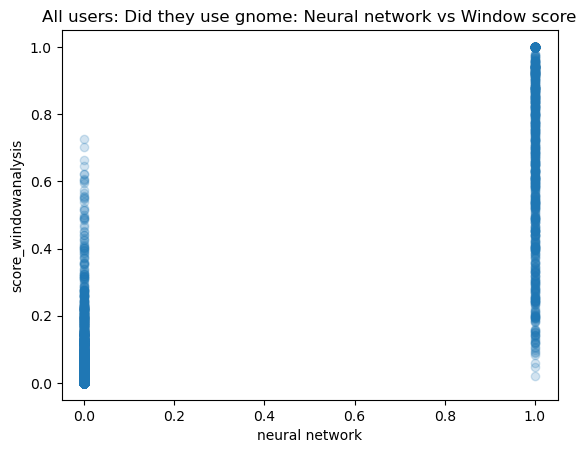

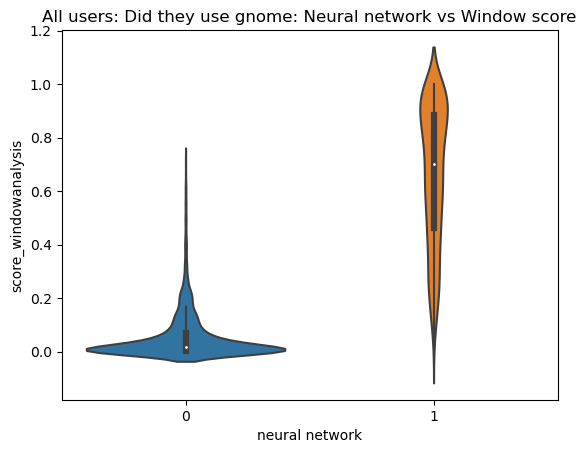

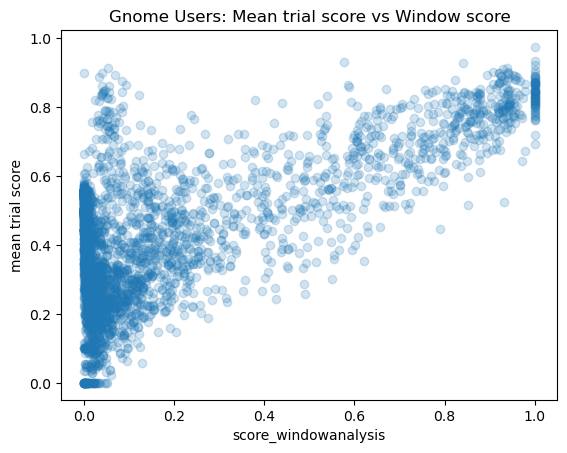

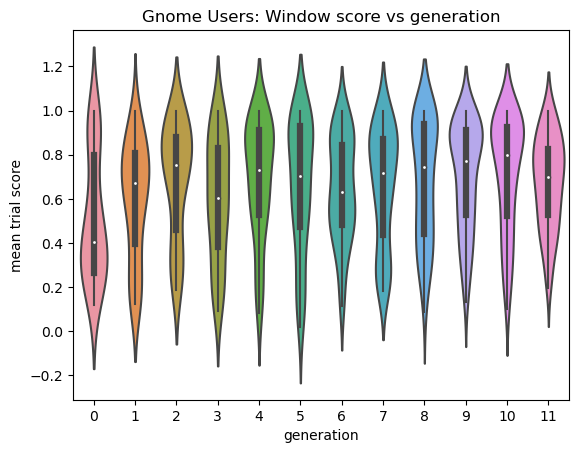

In [31]:
fig1 = plt.figure()
plt.scatter(df_scores['gnome_nn_01'], df_scores['score'],alpha=0.2)
plt.xlabel('neural network')
plt.ylabel('score_windowanalysis')
plt.title('All users: Did they use gnome: Neural network vs Window score')

fig2 = plt.figure()
sns.violinplot(x='gnome_nn_01', y='score', data=df_scores)
plt.xlabel('neural network')
plt.ylabel('score_windowanalysis')
plt.title('All users: Did they use gnome: Neural network vs Window score')


fig3 = plt.figure()
plt.scatter(df_scores['score'], df_scores['mean_trial_score'],alpha=0.2)
plt.xlabel('score_windowanalysis')
plt.ylabel('mean trial score')
plt.title('Gnome Users: Mean trial score vs Window score')

fig4 = plt.figure()
sns.violinplot(x='generation', y='score', data=df_scores[df_scores['gnome_nn_01']==1])
plt.xlabel('generation')
plt.ylabel('mean trial score')
plt.title('Gnome Users: Window score vs generation')

# fig2=df_scores[df_scores['gnome_nn_01']==1].plot(x='score', y='mean_trial_score', style='o',alpha=0.2,xlabel='score_windowanalysis',ylabel='mean trial score',title='Gnome Users: Mean trial score vs Window score')
# fig3=df_scores[df_scores['gnome_nn_01']==1].plot(x='generation', y='score', style='o',alpha=0.2,xlabel='generation',ylabel='score_windowanalysis',title='Window score vs generation')

In [30]:
import statsmodels.formula.api as smf
model = smf.ols(formula='score ~ generation ', data=df_scores).fit()

# Print a detailed summary (similar to R's summary(lm))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     97.91
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           8.55e-23
Time:                        22:39:36   Log-Likelihood:                -496.26
No. Observations:                3600   AIC:                             996.5
Df Residuals:                    3598   BIC:                             1009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1043      0.009     11.977      0.0

In [19]:
query = """
CREATE OR REPLACE TABLE Transmission_Table AS
    SELECT 
        networks.parent_participant_id as parent_id,
        networks.participant_id as pid,
        networks.parent_rank as rank_parent,
        parent_participant.algo_type as parent_algo,
        child_participant.algo_type as child_algo,
        CASE 
        WHEN child_participant.algo_type = 1 THEN 1 
        ELSE 0 
        END AS child_gnome
    FROM networks
    LEFT JOIN Participant_Table as parent_participant
    ON parent_participant.pid=networks.parent_participant_id
    LEFT JOIN Participant_Table as child_participant
    ON child_participant.pid=networks.participant_id
    WHERE networks.parent_participant_id IS NOT NULL and parent_participant.algo_type=1; 


SELECT 
parent_id as pid,
--max(rank_parent) as rank,
COUNT(pid) AS n_children,
SUM(child_gnome) AS n_algochildren,
FROM Transmission_Table
GROUP BY parent_id;




"""

# Execute queries
df_Network = con.execute(query).df()

# Display results
df_Network

,pid,n_children,n_algochildren
0,40.0,3,0.0
1,1940.0,5,4.0
2,2008.0,5,2.0
3,2725.0,4,2.0
4,2550.0,3,0.0
...,...,...,...
532,3550.0,3,1.0
533,3490.0,2,0.0
534,2764.0,1,0.0
535,3135.0,1,1.0


In [20]:
score_trans=pd.merge(df_scores,df_Network, on='pid', how='left')

alpha=1
beta=1
score_trans['p_trans']=(alpha+score_trans['n_algochildren'])/(alpha+beta+score_trans['n_children'])
score_trans

,pid,score,generation,gnome_nn_01,mean_trial_score,n_children,n_algochildren,p_trans
0,0,0.000952,0,0,0.405639,NaN,NaN,NaN
1,1,0.075452,0,0,0.222832,NaN,NaN,NaN
2,2,0.026717,0,0,0.292058,NaN,NaN,NaN
3,3,0.048467,0,0,0.234758,NaN,NaN,NaN
4,4,0.044482,0,0,0.438314,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3595,3595,0.724798,11,0,0.744710,NaN,NaN,NaN
3596,3596,0.370762,11,0,0.479483,NaN,NaN,NaN
3597,3597,0.154625,11,0,0.547124,NaN,NaN,NaN
3598,3598,0.050580,11,0,0.229368,NaN,NaN,NaN


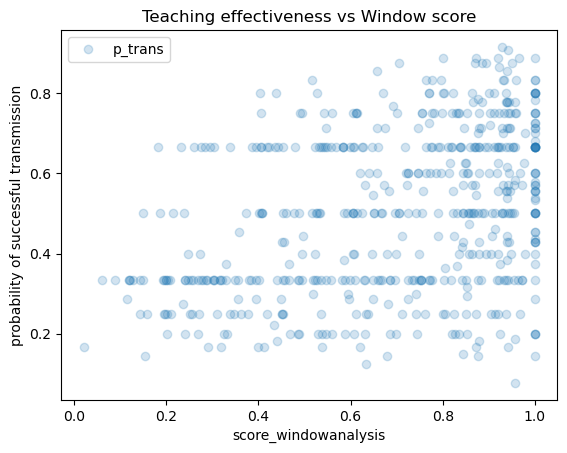

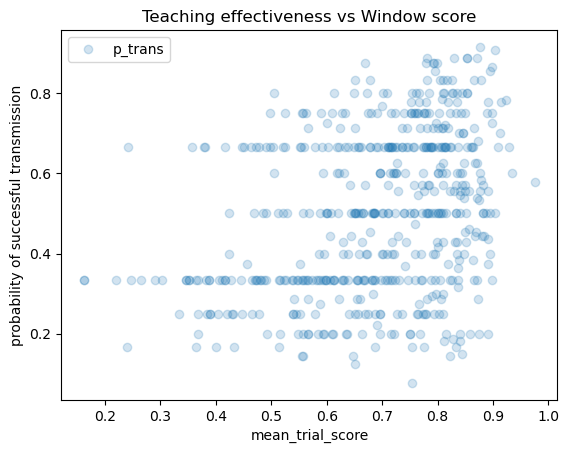

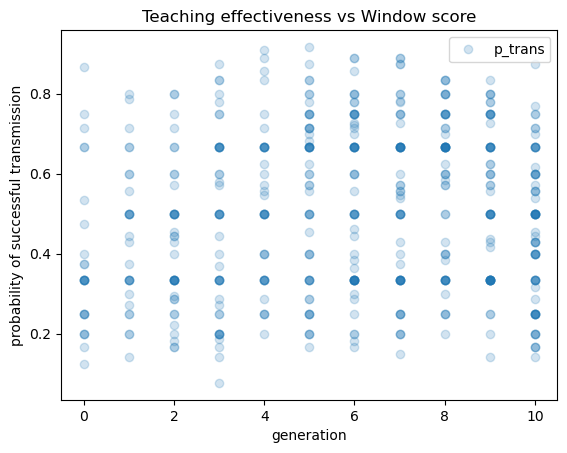

In [ ]:
fig4=score_trans.plot(x='score', y='p_trans', style='o',alpha=0.2,xlabel='score_windowanalysis',ylabel='probability of successful transmission',title='Teaching effectiveness vs Window score')
fig4_2=score_trans.plot(x='mean_trial_score', y='p_trans', style='o',alpha=0.2,xlabel='mean_trial_score',ylabel='probability of successful transmission',title='Teaching effectiveness vs mean_trial_score')

fig5=score_trans.plot(x='generation', y='p_trans', style='o',alpha=0.2,xlabel='generation',ylabel='probability of successful transmission',title='Probability of successful transmission vs Generation')

In [29]:
query_check = """
SELECT 
    parent_id,
    pid,
    parent_algo,
    child_algo
FROM Transmission_Table
WHERE parent_id=8

"""

# Execute queries
results_check = con.execute(query_check).df()

# Display results
results_check.head(10)

,parent_id,pid,parent_algo,child_algo
0,8.0,137,1.0,0.0
1,8.0,173,1.0,8.0
2,8.0,108,1.0,0.0
